# Exploratory Data Analysis of Powercreep in Pokemon

Original dataset taken from Josh Korngiebel on Kaggle.
https://www.kaggle.com/datasets/jkorn28/pokemon-stats-gens-1-9 

Dataset modified by me in the data prep folder. All operations in this notebook will be using the modified csv file.

## <h1 style="text-align: center;">Introduction</h1>

### **Background**

Standing head and shoulders over every single media company and intellectual property group in the world is Pokemon. As the highest grossing media franchise of all time, Pokemon has cemented, no matter how big or small, a place in the minds of almost everyone. Because of the many games and multiplayer features added, communities of hobbyists dedicated to competitive Pokemon battling have developed. 

These hobbyists have developed remarkably optimized Pokemon teams, and continue to battle online with a thriving competitive scene. Everytime a new generation of Pokemon is released, the online competitive scene has to scramble to adjust to what has been deemed "powercreep". Powercreep is a term used throughout gaming to generally refer to the phenomenon of new > old, that is, new content released by the maker of the game more often than not tend to outclass older content. The most recent Pokemon generation, generation 9, has been a particularly emblematic piece of this gaming standard.

### **Goal**

Leveraging Python libraries, we hope to both quantify and visualize the effect of powercreep. This will be done by analyzing the inclusion of certain factors that tend to increase the power level of Pokemon by generation. Or, in the case that no clear distinction is shown by broad analysis, check to see if there is noticeable powercreep to begin with. The ultimate goal is to see if there are easy factors that lead to powercreep. We should be able to see a distinct gap in power between generation 9 and the others.

## <h1 style="text-align: center;">Table of Contents</h1>

1. The Data
    - Loading
        - Relevance
    - Previewing & Explaining
    - Error Testing
        - The Extreme Outlier
        - Suspicious Stats
        - Type Testing
1. Analysis
    - Smogon Usage
        - Usage Breakdown Across Tiers
    - Stat Distributions
        - Generational Averages and Medians
        - Generational Distributions
    - Type Strength
        - Offensive
        - Defensive
    - Special Pokemon
        - Legendaries
        - Mythicals
        - Notables
        - "Optimized" Pokemon
1. Conclusions
    

## <h1 style="text-align: center;">The Data</h1>

### **Loading (+ Libraries)**

In [664]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from itertools import combinations
from scipy.stats import gaussian_kde

In [641]:
pokedf = pd.read_csv('pokemon_data_custom.csv')

The data has already been prepared in another folder on this repository. For more detailed information on what changes were made to the original dataset by Josh Korngiebel, refer to that folder. Briefly, useful columns were added for classification, and 7 missing Pokemon were added.

#### Relevance

For relevance, I will be removing Mega and Primal Pokemon, as those Pokemon are limited to past generations as gimmicks. It would not be fair to include them, as other generations' gimmicks cannot be quantified either, such as generation 9's terastalization.

In [642]:
# removing mega's and primals
pokedf = pokedf[~pokedf['Name'].str.contains('Mega ')]
pokedf = pokedf[~pokedf['Name'].str.contains('Primal ')]

### **Previewing & Explaining**

In [643]:
pokedf.head()

,Dex No,Name,Base Name,Type 1,Type 2,BST,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation,Legendary,Mythical,Notable
0,1,Bulbasaur,Bulbasaur,GRASS,POISON,318,45,49,49,65,65,45,1,False,False,False
1,2,Ivysaur,Ivysaur,GRASS,POISON,405,60,62,63,80,80,60,1,False,False,False
2,3,Venusaur,Venusaur,GRASS,POISON,525,80,82,83,100,100,80,1,False,False,False
4,4,Charmander,Charmander,FIRE,-,309,39,52,43,60,50,65,1,False,False,False
5,5,Charmeleon,Charmeleon,FIRE,-,405,58,64,58,80,65,80,1,False,False,False


In [644]:
pokedf.tail()

,Dex No,Name,Base Name,Type 1,Type 2,BST,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation,Legendary,Mythical,Notable
1196,1013,Sinistcha,Sinistcha,GRASS,GHOST,508,71,60,106,121,80,70,9,False,False,False
1197,1014,Okidogi,Okidogi,POISON,FIGHTING,555,88,128,115,58,86,80,9,True,False,False
1198,1015,Munkidori,Munkidori,POISON,PSYCHIC,555,88,75,66,130,90,106,9,True,False,False
1199,1016,Fezandipiti,Fezandipiti,POISON,FAIRY,555,88,91,82,70,125,99,9,True,False,False
1200,1017,Ogerpon,Ogerpon,GRASS,-,550,80,120,84,60,96,110,9,True,False,False


The data contains 16 columns.
- Dex No: Refers to the official *Pokedex* number, of the Pokemon. Every Pokemon has a unique Pokedex number, or as it will be referred to, Dex number.

- Name: Self explanatory with one caveat, certain Pokemon are considered *alternate forms*, that is, they are the same species of Pokemon, but simply a different variant. One example is the Mega Venusaur visible in the dataframe head. Notice the entry shares the same Dex number as its base form, Venusaur.

- Base Name: Every Pokemon has the same Base Name as Name, except the aformentioned variants, who instead have the name of the original form.

- Type 1 and 2: There are 18 elemental "types" of Pokemon, which will be explained in more detail later. Notice that not all Pokemon have two types, some only have one. In that case, the Type 2 column will have a placeholder '-'.

- BST, HP, Attack, Defense, Sp. Attack, Sp. Defense, and Speed: HP through Speed all refer to different stats of a Pokemon. "Sp" in two of the columns stands for "Special" which just refers to a slightly different but equally important Attack and Defense stat. "HP" stands for "Health Points". BST is simply the total of these six fundamental stats. Note that higher = better when it comes to stats.

- Generation: Pokemon are released not one by one, but in large batches, referred to as "Generations", or more colloquially, just "Gens". There are currently nine generations of Pokemon, and this column assigns the corresponding generation number to each Pokemon. 

- Legendary, Mythical, and Notable: These are all special classes of Pokemon. Legendary and Mythical and official designations by the Pokemon Company. Notable is a classification I have chosen to add to Pokemon that miscellaneously special, and are not officially Legendary or Mythical.

### **Error Testing**

#### The Extreme Outlier

Publicly online we can see what should be the highest and lowest stats in each category, so it should be simple to see if there are any extreme outliers. Before we do this, we will manually remove a Pokemon that, while technically is in the Pokedex, is not obtainable in game, and therefore should not be considered. This Pokemon is Eternamax Eternatus, a Pokemon meant only as a one-time boss battle.

This was not done in the data prep file in order to not have a missing Pokemon in case anyone else wishes to use the csv file.

In [645]:
pokedf = pokedf[pokedf['Name'] != "Eternamax"]

In [646]:
# verify that the Pokemon was removed by checking for all Pokemon with its Base Name
pokedf[pokedf['Base Name'] == "Eternatus"]

,Dex No,Name,Base Name,Type 1,Type 2,BST,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Generation,Legendary,Mythical,Notable
1057,890,Eternatus,Eternatus,POISON,DRAGON,690,140,85,95,145,95,130,8,True,False,False


#### Suspicious Values

In [647]:
# highest and lowest recorded stats taken directly from the online resource, Bulbapedia
stat_extremes = {
    'BST': {'min': 175, 'max': 1125},
    'HP': {'min': 1, 'max': 255},
    'Attack': {'min': 5, 'max': 190},
    'Defense': {'min': 5, 'max': 230},
    'Sp. Attack': {'min': 10, 'max': 194},
    'Sp. Defense': {'min': 20, 'max': 230},
    'Speed': {'min': 5, 'max': 200}
}

# iterate through the stats
for stat, extremes in stat_extremes.items():
    min_value = extremes['min']
    max_value = extremes['max']

    # store checks as booleans
    has_below_min = (pokedf[stat] < min_value).any()
    has_above_max = (pokedf[stat] > max_value).any()

    # print results
    if has_below_min:
        print(f"At least one Pokémon has a {stat} stat below {min_value}.")

    if has_above_max:
        print(f"At least one Pokémon has a {stat} stat above {max_value}.")

    if not has_below_min and not has_above_max:
        print(f"No Pokémon have {stat} stats below {min_value} or above {max_value}.")


No Pokémon have BST stats below 175 or above 1125.
No Pokémon have HP stats below 1 or above 255.
No Pokémon have Attack stats below 5 or above 190.
No Pokémon have Defense stats below 5 or above 230.
No Pokémon have Sp. Attack stats below 10 or above 194.
No Pokémon have Sp. Defense stats below 20 or above 230.
No Pokémon have Speed stats below 5 or above 200.


There aren't any major outlying values. Previously, there were due to Eternamax Eternatus, which I removed from the dataset in the preparation, due to the fact that it is not a player usable Pokemon.

#### Type Testing

A simple test to make sure there are no typos or unexpected values for the Pokemon types.

In [648]:
print(f"Number of unique values in 'Type 1' column: {pokedf['Type 1'].nunique()}")
print(f"Number of unique values in 'Type 2' column: {pokedf['Type 2'].nunique()}")

Number of unique values in 'Type 1' column: 18
Number of unique values in 'Type 2' column: 19


There are 18 types in Pokemon, and for the dataset, a placeholder '-' for the secondary typing of monotype Pokemon, so there are no unexpected values.

With that, we have finished verifying the accuracy of our dataset. Note that mispellings of Pokemon names could be present, but since in the data preparation we made sure that all Pokemon are labelled with the correct generation, it doesn't matter whether there are any spelling mistakes in names.

## <h1 style="text-align: center;">Analysis</h1>

### **Smogon Usage**


Smogon is a competitive Pokemon community that focuses on creating and maintaining a balanced and competitive environment for Pokemon battles. The official Smogon website allows anyone to easily experiment with different Pokemon teams without spending the many hours it would take to train the teams in-game. It's a valuable resource for competitive Pokemon players looking to improve their skills and engage in fair battles.

Smogon is known for its tier system, which classifies Pokemon into different tiers based on their usage and power in battles. These tiers include Uber, OU (OverUsed), UU (UnderUsed), RU (RarelyUsed), NU (NeverUsed), and more. In this analysis, we will only focus on the top tiers of play, OU and Ubers.

#### Usage Breakdown Across Tiers

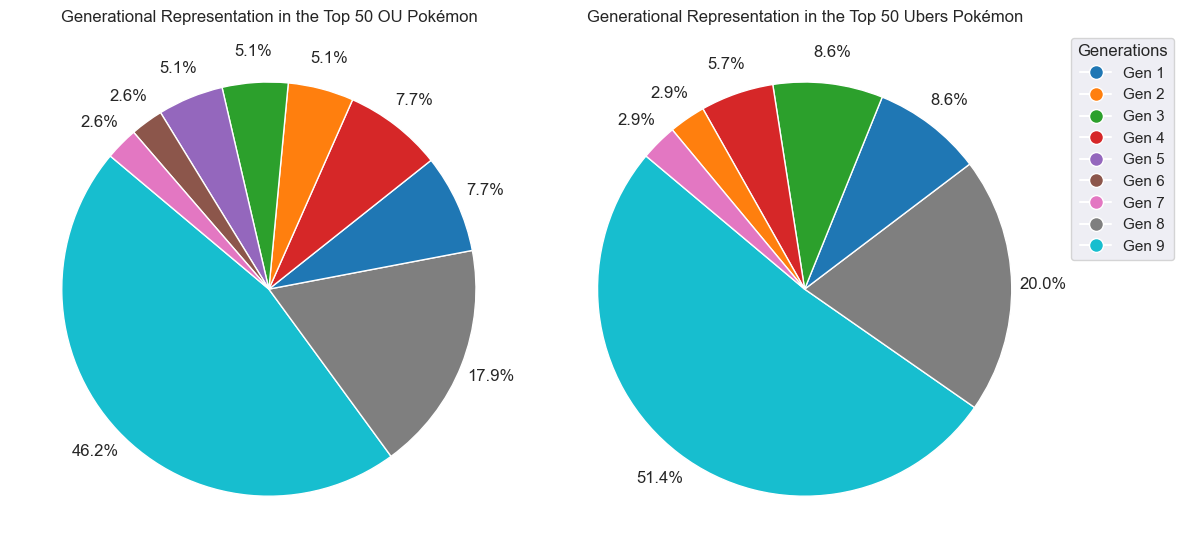

In [649]:
# open the txt Smogon file and read its contents, splitting it into lines
with open('smogon.com_stats_2023-08_gen9ou-1825.txt', 'r') as file:
    smogon_usage_OU = file.read().splitlines()

# initialize an empty list to store the parsed data
parsed_OU_data = []

# iterate through the lines and extract the ranking, name, and usage
for line in smogon_usage_OU:

    # split each line by '|' which are on the original text file
    elements = line.split('|')
    
    # check if the line contains data for a Pokémon (lines containing '| Rank |' are headers)
    # assign the corresponding info from each line
    if len(elements) >= 8:
        rank = elements[1].strip()
        pokemon_name = elements[2].strip()
        usage_percentage = elements[3].strip()
        
        # throw the parsed data in the list
        parsed_OU_data.append({
            'Rank': rank,
            'Pokemon': pokemon_name,
            'Usage %': usage_percentage,
        })

# same process used as the OU tier
with open('smogon.com_stats_2023-08_gen9ubers-1760.txt', 'r') as file:
    smogon_usage_ubers = file.read().splitlines()

# initialize an empty list to store the parsed data
parsed_ubers_data = []

# iterate through the lines and extract the ranking, name, and usage
for line in smogon_usage_ubers:
    
    # split each line by '|' which are on the original text file
    elements = line.split('|')
    
    # check if the line contains data for a Pokémon (lines containing '| Rank |' are headers)
    # assign the corresponding info from each line
    if len(elements) >= 8:
        rank = elements[1].strip()
        pokemon_name = elements[2].strip()
        usage_percentage = elements[3].strip()
        
        # throw the parsed data in the list
        parsed_ubers_data.append({
            'Rank': rank,
            'Pokemon': pokemon_name,
            'Usage %': usage_percentage,
        })

# use the parsed data from the OU and Uber tiers to compare back to the main dataframe to reference the generation of each Pokemon
# filter the top 50 ranked Pokémon for OU
top_50_OU = parsed_OU_data[:50]

# filter the top 50 ranked Pokémon for Ubers
top_50_Ubers = parsed_ubers_data[:50]





# define the colors so that both plots have consistent generation labels
master_generation_colors = {
    1: 'tab:blue',
    2: 'tab:orange',
    3: 'tab:green',
    4: 'tab:red',
    5: 'tab:purple',
    6: 'tab:brown',
    7: 'tab:pink',
    8: 'tab:gray',
    9: 'tab:cyan'
}

# create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# iterate over the tiers and data
for i, (tier_name, top_50_data, generation_colors) in enumerate([
    ('OU', top_50_OU, master_generation_colors),
    ('Ubers', top_50_Ubers, master_generation_colors)
]):

    # extract names of the top 50 Pokémon
    top_50_names = [entry['Pokemon'] for entry in top_50_data]

    # filter the pokedf to include only the top 50 Pokémon
    top_50_df = pokedf[pokedf['Name'].isin(top_50_names)]

    # count the number of Pokémon in each generation among the top 50
    generation_counts = top_50_df['Generation'].value_counts()

    # create a pie chart for each tier
    axs[i].pie(
        generation_counts,
        autopct = '%1.1f%%',
        startangle = 140,
        colors = [generation_colors[gen] for gen in generation_counts.index],
        pctdistance = 1.15
    )
    axs[i].set_title(f'Generational Representation in the Top 50 {tier_name} Pokémon')


# putting the legend in the second plot only since both plots use the same colors for different gens
legend_items = [plt.Line2D([0], [0], marker = 'o', color = 'w', label = f'Gen {gen}', markerfacecolor = color, markersize = 10) 
                for gen, color in master_generation_colors.items()]

# add legend to second plot
axs[1].legend(handles = legend_items, title = 'Generations', loc = 'upper left', bbox_to_anchor = (1, 1))


# better layout
plt.tight_layout()
plt.show()


As we can see, the last two generations alone compromise over 60% of the top 50 OU (standard play) Pokemon. In addition, they compromise over 70% of top 50 Ubers (a tier reserved for the strongest Pokemon). Whether or not we find notable signifiers of powercreep after this or not, there is clear evidence of its existence.

### **Stat Distributions**

#### Generational Averages and Medians

One of the most general (but not comprehensive) ways to check for the strength of a Pokemon is by checking their aptly named *Base Stat Total*, or BST. Athough the distribution of base stats matters just as much, generally, Pokemon with a higher BST tend to be stronger overall. Error bars were removed from the graph as since all Pokemon are in the dataset, there is no error.

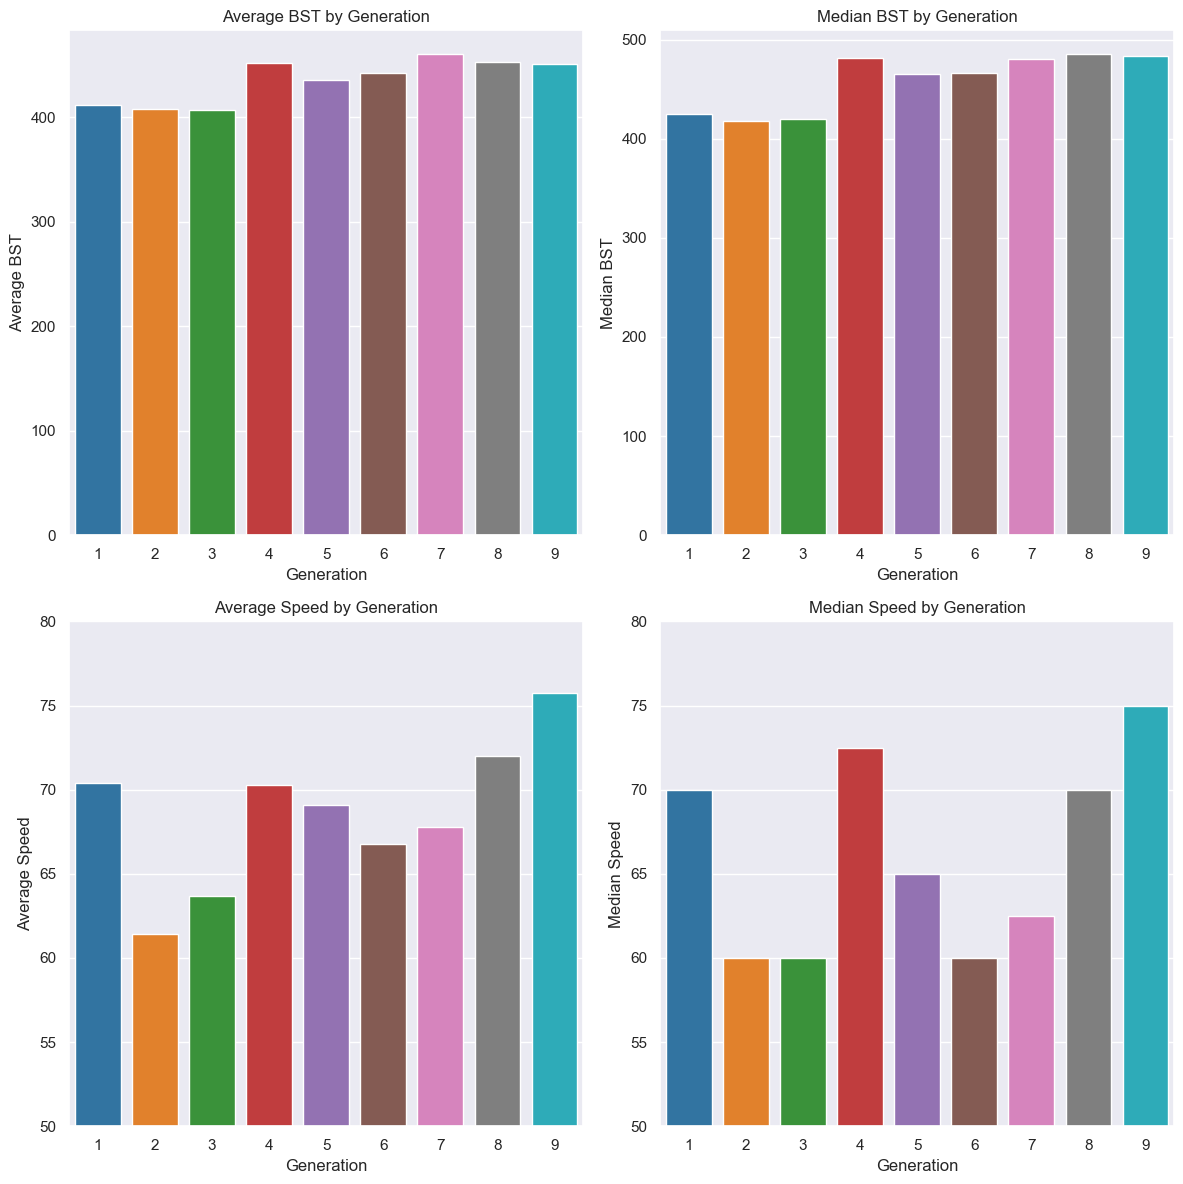

In [650]:
# define generation colors, all graphs in this notebook will use the same colors
master_generation_colors = {
    1: 'tab:blue',
    2: 'tab:orange',
    3: 'tab:green',
    4: 'tab:red',
    5: 'tab:purple',
    6: 'tab:brown',
    7: 'tab:pink',
    8: 'tab:gray',
    9: 'tab:cyan'
}

# create a figure with a 2x2 grid to display all subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# plot the average BST by generation on the first subplot
sns.barplot(x='Generation', y='BST', errorbar=None, data=pokedf, ax=axes[0, 0], palette=master_generation_colors.values())
axes[0, 0].set_title("Average BST by Generation")
axes[0, 0].set_xlabel("Generation")
axes[0, 0].set_ylabel("Average BST")

# plot the average Speed by generation on the second subplot
# y-axis is limited because even a small speed difference makes a large difference in a Pokemon's power
# speed margin doesn't matter when deciding who moves first, so essentially losing in speed in a 5 vs 100 scenario is equally as bad as losing in speed in a 99 vs 100 scenario
sns.barplot(x='Generation', y='Speed', errorbar=None, data=pokedf, ax=axes[1, 0], palette=master_generation_colors.values())
axes[1, 0].set_title("Average Speed by Generation")
axes[1, 0].set_xlabel("Generation")
axes[1, 0].set_ylabel("Average Speed")
axes[1, 0].set_ylim(50, 80)

# plot the median BST by generation on the third subplot
sns.barplot(x='Generation', y='BST', estimator=np.median, errorbar=None, data=pokedf, ax=axes[0, 1], palette=master_generation_colors.values())
axes[0, 1].set_title("Median BST by Generation")
axes[0, 1].set_xlabel("Generation")
axes[0, 1].set_ylabel("Median BST")

# plot the median Speed by generation on the fourth subplot
# same reasoning with the y-axis limits here
sns.barplot(x='Generation', y='Speed', estimator=np.median, errorbar=None, data=pokedf, ax=axes[1, 1], palette=master_generation_colors.values())
axes[1, 1].set_title("Median Speed by Generation")
axes[1, 1].set_xlabel("Generation")
axes[1, 1].set_ylabel("Median Speed")
axes[1, 1].set_ylim(50, 80)

# better layout
plt.tight_layout()
plt.show()


#### Generational Distributions

As important as the overall power level of a generation is, it only takes a small subset of noticeably powerful Pokemon to initiate powercreep. Therefore we will also be testing the distributions of stats throughout the generations.

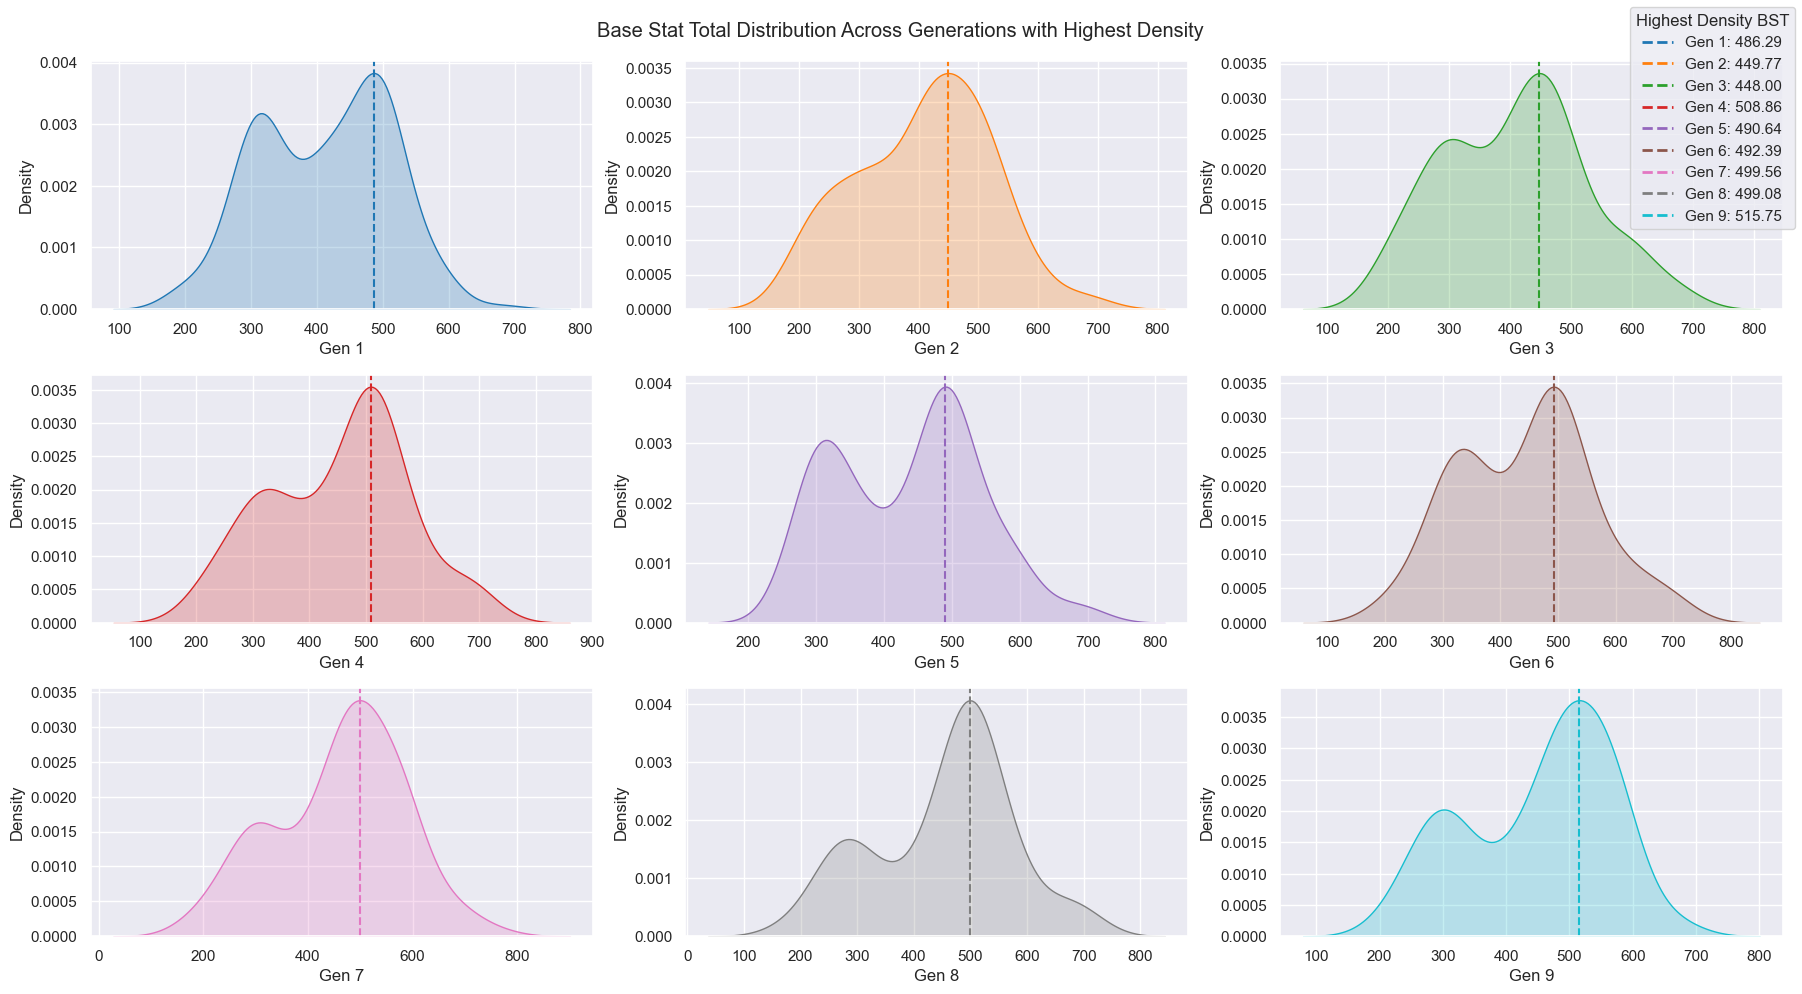

In [679]:
# subplots, had to make them very big so there would be space for the legend
fig, axs = plt.subplots(3, 3, figsize=(18, 10))

# flattening axes for indexing
axs = axs.flatten()

# dictionary for storing highest density points
highest_density_points = {}

# iterate through generations to create kde plots faster
for i in range(1, 10):
    generation_data = pokedf[pokedf['Generation'] == i]
    sns.kdeplot(data = generation_data, x = 'BST', fill = True, color = master_generation_colors[i], ax = axs[i - 1])
    
    # calc kde values
    kde = gaussian_kde(generation_data['BST'])
    x = np.linspace(generation_data['BST'].min(), generation_data['BST'].max(), 1000)
    y = kde(x)
    
    # find x-coords of highest density point
    max_density_x = x[y.argmax()]
    
    # store highest density for current gen
    highest_density_points[f'Gen {i}'] = max_density_x
    
    # plot vertical line at that x value
    axs[i - 1].axvline(max_density_x, color = master_generation_colors[i], linestyle = 'dashed', label = f'Highest Density (Gen {i}): {max_density_x:.2f}')
    
    # axis titles
    axs[i - 1].set_xlabel(f'Gen {i}')
    axs[i - 1].set_ylabel('Density')

# main plot title
fig.suptitle('Base Stat Total Distribution Across Generations with Highest Density')

# highest density points legend
legend_labels = [f'{i}: {value:.2f}' for i, value in highest_density_points.items()]
legend_handles = [plt.Line2D([0], [0], color = master_generation_colors[i], linestyle = 'dashed', lw = 2) for i in range(1, 10)]
# display legend
fig.legend(legend_handles, legend_labels, loc = 'upper right', title = 'Highest Density BST')

# better layout
plt.tight_layout()
plt.show()


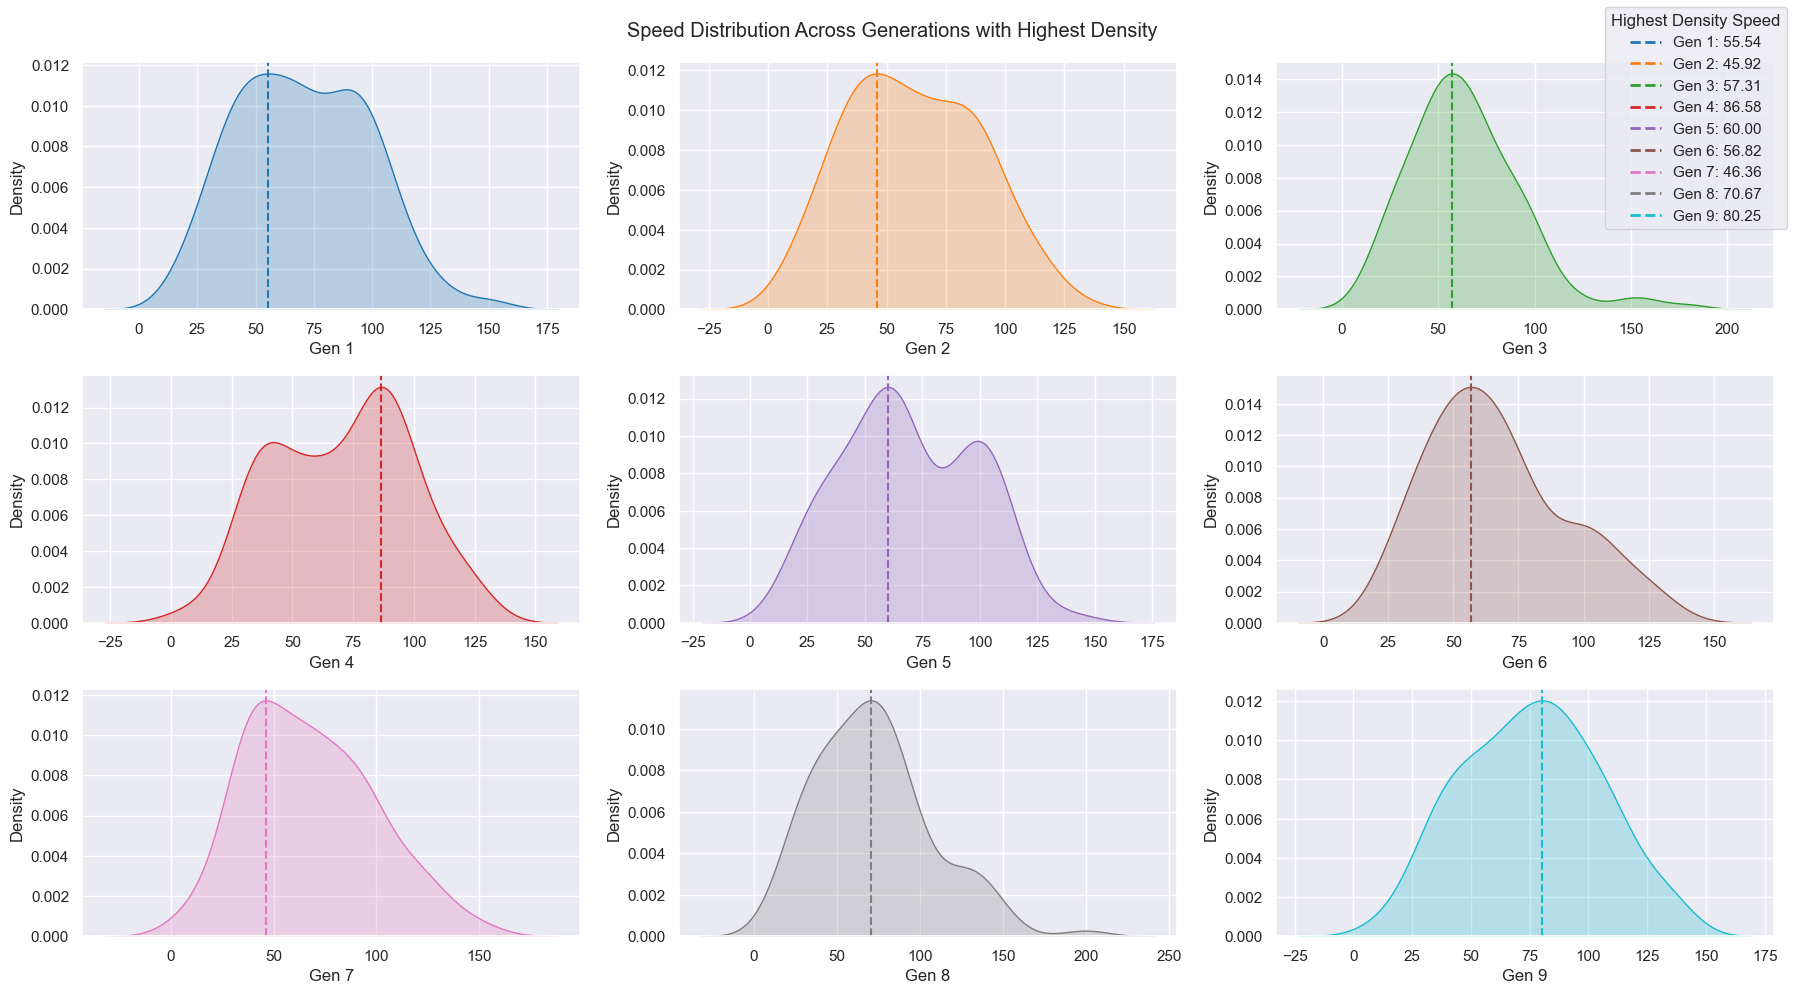

In [683]:
# subplots, had to make them very big so there would be space for the legend
fig, axs = plt.subplots(3, 3, figsize=(18, 10))

# flattening axes for indexing
axs = axs.flatten()

# dictionary for storing highest density points
highest_density_points = {}

# iterate through generations to create kde plots faster
for i in range(1, 10):
    generation_data = pokedf[pokedf['Generation'] == i]
    sns.kdeplot(data = generation_data, x = 'Speed', fill = True, color = master_generation_colors[i], ax = axs[i - 1])
    
    # calc kde values
    kde = gaussian_kde(generation_data['Speed'])
    x = np.linspace(generation_data['Speed'].min(), generation_data['Speed'].max(), 1000)
    y = kde(x)
    
    # find x-coords of highest density point
    max_density_x = x[y.argmax()]
    
    # store highest density for current gen
    highest_density_points[f'Gen {i}'] = max_density_x
    
    # plot vertical line at that x value
    axs[i - 1].axvline(max_density_x, color = master_generation_colors[i], linestyle = 'dashed', label = f'Highest Density (Gen {i}): {max_density_x:.2f}')
    
    # axis titles
    axs[i - 1].set_xlabel(f'Gen {i}')
    axs[i - 1].set_ylabel('Density')

# main plot title
fig.suptitle('Speed Distribution Across Generations with Highest Density')

# highest density points legend
legend_labels = [f'{i}: {value:.2f}' for i, value in highest_density_points.items()]
legend_handles = [plt.Line2D([0], [0], color = master_generation_colors[i], linestyle = 'dashed', lw = 2) for i in range(1, 10)]
# display legend
fig.legend(legend_handles, legend_labels, loc = 'upper right', title = 'Highest Density Speed')

# better layout
plt.tight_layout()
plt.show()

There is a noticable uptick in speed in the newest generations, 8 and 9. Speed is arguably the most important stat in all of Pokemon, because it determines mover order. In many 1v1 scenarios, even if the slower Pokemon is more powerful, it still loses. 

Although the overall base stats have remained relatively consistent, the speed gap alone may be a large factor in the success of recent generations competitively.

### **Type Strength**

Pokemon come in different types. Some Pokemon have only one type, called *monotypes*. Others have two types, known as *dual typing* Pokemon. This section is just meant to be a general look at the relative strength of different types.

#### Offensive

In [654]:
# rank types by offensive strength
# possibly a heat map with the sum of offensive typing advantage as the color

poke_typechart = pd.read_csv('poke_type_chart.csv', index_col = 0)

# the offensive type ranking combinations will be ranked by the total number of types that it is super effective against
offensive_strength = {}
for index, row in poke_typechart.iterrows():
    strength = sum(1 for value in row.values if value > 1.0)
    offensive_strength[index] = strength

# rank the offensive types in order
print(dict(sorted(offensive_strength.items(), key=lambda x: x[1], reverse=True)))



{'Fighting': 5, 'Ground': 5, 'Fire': 4, 'Ice': 4, 'Rock': 4, 'Water': 3, 'Grass': 3, 'Flying': 3, 'Bug': 3, 'Steel': 3, 'Fairy': 3, 'Electric': 2, 'Poison': 2, 'Psychic': 2, 'Ghost': 2, 'Dark': 2, 'Dragon': 1, 'Normal': 0}


As we can see, Fighting and Ground types have the most offense prowess, as they hit 5 different types for 2x damage.

#### Defensive

In [655]:
# opposite of offensive, almost same procedure
# we add a point for having a resistance and take away a point for having a weakness
# immunities are three points
defensive_strength = {}
for column in poke_typechart.columns:
    strength = 0
    for value in poke_typechart[column]:
        if value < 1.0:
            strength += 1
        elif value > 1.0:
            strength -= 1
        elif value == 0:
            strength += 3
    defensive_strength[column] = strength

print(dict(sorted(defensive_strength.items(), key=lambda x: x[1], reverse=True)))

{'Steel': 8, 'Fire': 3, 'Poison': 3, 'Water': 2, 'Electric': 2, 'Ghost': 2, 'Fairy': 2, 'Flying': 1, 'Dragon': 1, 'Normal': 0, 'Fighting': 0, 'Ground': 0, 'Bug': 0, 'Dark': 0, 'Grass': -1, 'Psychic': -1, 'Rock': -1, 'Ice': -3}


Steel types rein as the strongest defensive types by far. One common trait among strong OU and Uber threats are primary or secondary Steel typing.

### **Special Pokemon**

Not all Pokemon are created equal. There are certain special classes of Pokemon that are specifically designed to be more powerful. These are usually labelled as Legendary Pokemon, which are characteristically only available a single time per playthrough, or Mythical Pokemon, which are even rarer. Mythicals are only distributed to players under special events put on by Gamefreak (the publisher of Pokemon). Another class of Pokemon that I have distinguished are 'notable' Pokemon, which are just any other special Pokemon that aren't specifically listed as a Legendary of Mythical.

#### Legendaries

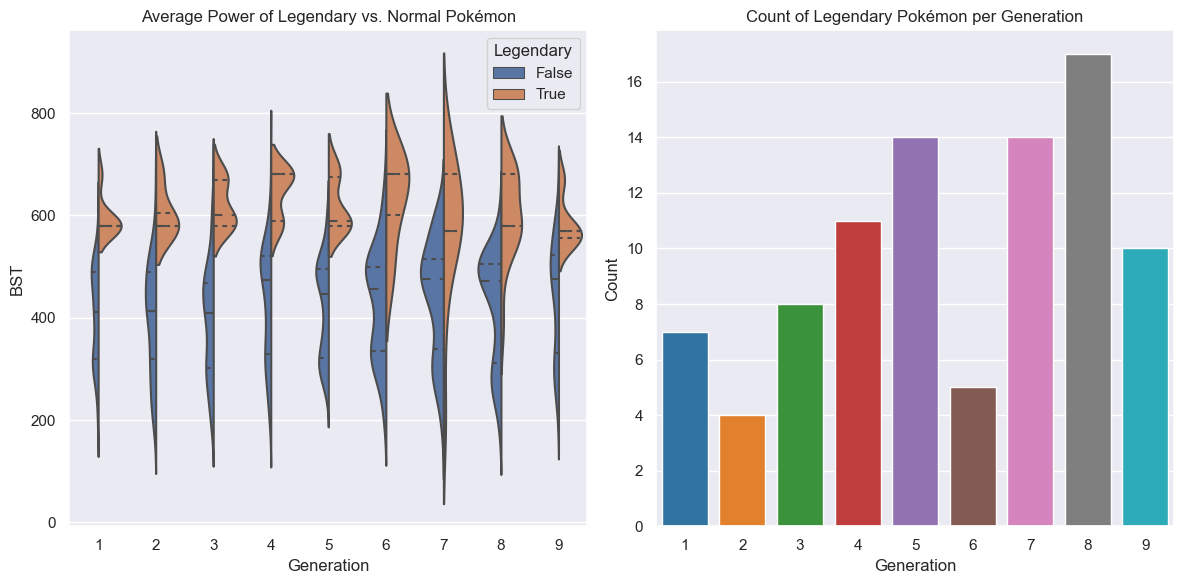

In [656]:
# calculate the average power of legendary vs non legendaries
legendary_avg_power = pokedf[pokedf['Legendary'] == True]['BST'].mean()
normal_avg_power = pokedf[(pokedf['Legendary'] == False) & 
                                (pokedf['Mythical'] == False) & 
                                (pokedf['Notable'] == False)]['BST'].mean()

# count the number of legendary pokemon per generation
legendary_per_generation = pokedf[pokedf['Legendary'] == True]['Generation'].value_counts().sort_index()

# create subplots
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

# plot the average power comparison
sns.violinplot(data = pokedf, x = "Generation", y = "BST", hue = "Legendary", split = True, inner = "quart", fill = False, ax = axs[0])
axs[0].set_title('Average Power of Legendary vs. Normal Pokémon')

# plot the count of legendary pokemon, using the standard colors ofc
sns.barplot(x = legendary_per_generation.index, y = legendary_per_generation.values, ax = axs[1],
            palette = [master_generation_colors[gen] for gen in legendary_per_generation.index])
axs[1].set_title('Count of Legendary Pokémon per Generation')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Count')

# better layout
plt.tight_layout()
plt.show()



With the exception of generation 6, the more recent generations tend to have many more legendary Pokemon than past generations. And on average, said legendary Pokemon tend to be significantly stronger (higher BST) than non-special Pokemon. An important distinction to notice is that while generations 6 and 9 seem to not be following this trend, they have thier own categories of Pokemon that while are not explicitly legendary, have elevated stats. For generation 6 these are the Ultra Beasts, and for generation 9, these are the Paradox Pokemon. In addition, generation 9, being the newest generation, still has new DLC (expansions) being released, where more legendaries are expected to join the fray.

#### Mythicals

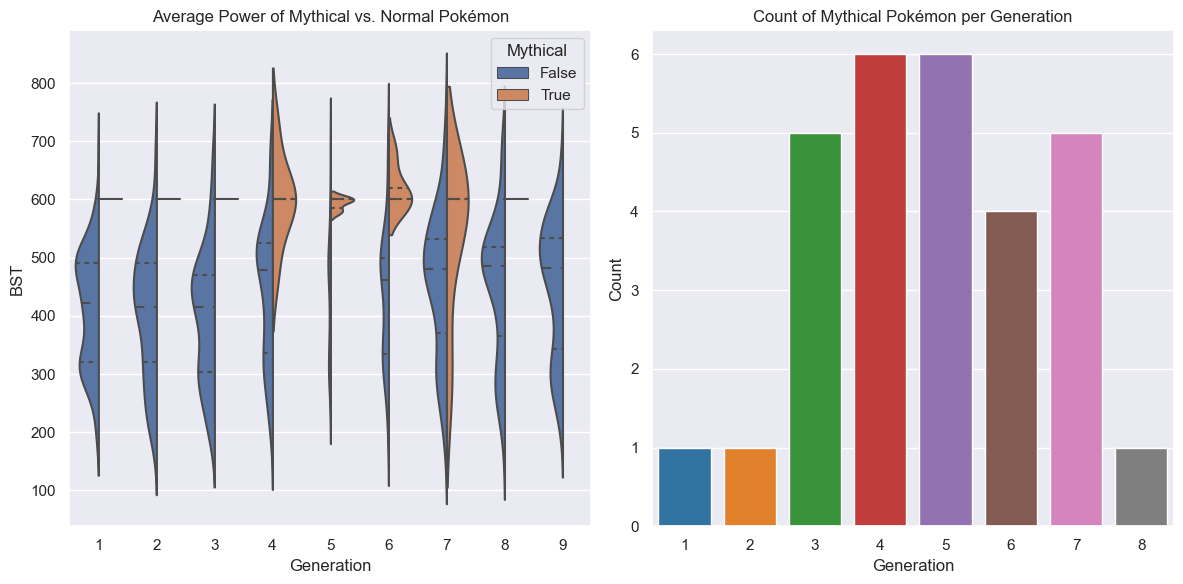

In [657]:
# basically same as legendaries
# one caveat is that they are usually restricted pokemon that arent allowed to be played, but for curiosities sake we might as well look at them

# calculate the average power of mythicals
mythical_avg_power = pokedf[pokedf['Mythical'] == True]['BST'].mean()

# count the number of mythical pokemon per generation
mythical_per_generation = pokedf[pokedf['Mythical'] == True]['Generation'].value_counts().sort_index()

# create subplots
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

# plot the average power comparison
sns.violinplot(data = pokedf, x = "Generation", y = "BST", hue = "Mythical", split = True, inner = "quart", fill = False, ax = axs[0])
axs[0].set_title('Average Power of Mythical vs. Normal Pokémon')


# plot the count of mythical pokemon, using the standard colors ofc
sns.barplot(x = mythical_per_generation.index, y = mythical_per_generation.values, ax = axs[1],
            palette = [master_generation_colors[gen] for gen in mythical_per_generation.index])
axs[1].set_title('Count of Mythical Pokémon per Generation')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Count')

# better layout
plt.tight_layout()
plt.show()


Similar to legendaries, we see that mythicals tend to be stronger than the average Pokemon, albeit to a lesser degree. Mythicals seem to have a much lesser effect on powercreep than legendaries. Generation 8 only has a single mythical, and generation 9 has yet to release one.

#### Notables

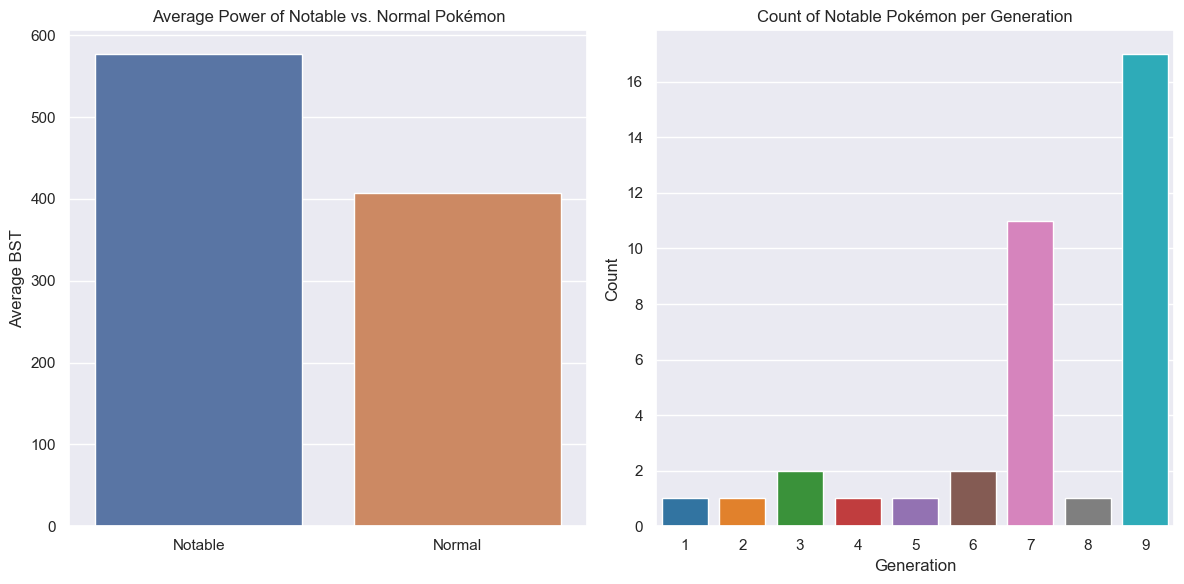

In [658]:
# handle this one a different way

# calculate the average power of mythicals
notable_avg_power = pokedf[pokedf['Notable'] == True]['BST'].mean()

# count the number of notable pokemon per generation
notable_per_generation = pokedf[pokedf['Notable'] == True]['Generation'].value_counts().sort_index()

# create subplots
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

# plot the average power comparison
sns.barplot(x = ['Notable', 'Normal'], y = [notable_avg_power, normal_avg_power], ax = axs[0])
axs[0].set_title('Average Power of Notable vs. Normal Pokémon')
axs[0].set_ylabel('Average BST')

# plot the count of legendary pokemon, using the standard colors ofc
sns.barplot(x = notable_per_generation.index, y = notable_per_generation.values, ax = axs[1],
            palette = [master_generation_colors[gen] for gen in notable_per_generation.index])
axs[1].set_title('Count of Notable Pokémon per Generation')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Count')

# better layout
plt.tight_layout()
plt.show()

Because of the very small number of notables in most generations, a simple average stat comparison is used rather than a violin plot to visualize the stat difference between notable Pokemon and normal Pokemon. As we see, notable Pokemon almost fill the gap of legendary Pokemon in the newer generations with less legendaries. They also are significantly stronger on average than normal Pokemon.

#### 'Optimized' Pokemon

Since we found earlier that the average BST of Pokemon hasn't changed much over time, we should try to see *how* those base stats have been distributed. Pokemon is a game of niches. A Pokemon built to achieve a specific purpose tends to outperform balanced Pokemon when teambuilding. 

For example, if you take 2 Pokemon with 600 BST, and you need to fill the attacker slot on your team, then it would be more beneficial to have a Pokemon that has more of those 600 stat points in the Attack categories than one that just has 100 in every category. Going even farther, let's say that the Pokemon only learns Special Attack moves, then it doesn't need a high physical Attack stat. 

I will refer to this concept of Pokemon with stats that are better distributed for their purpose as Pokemon that are better *min/maxed*.

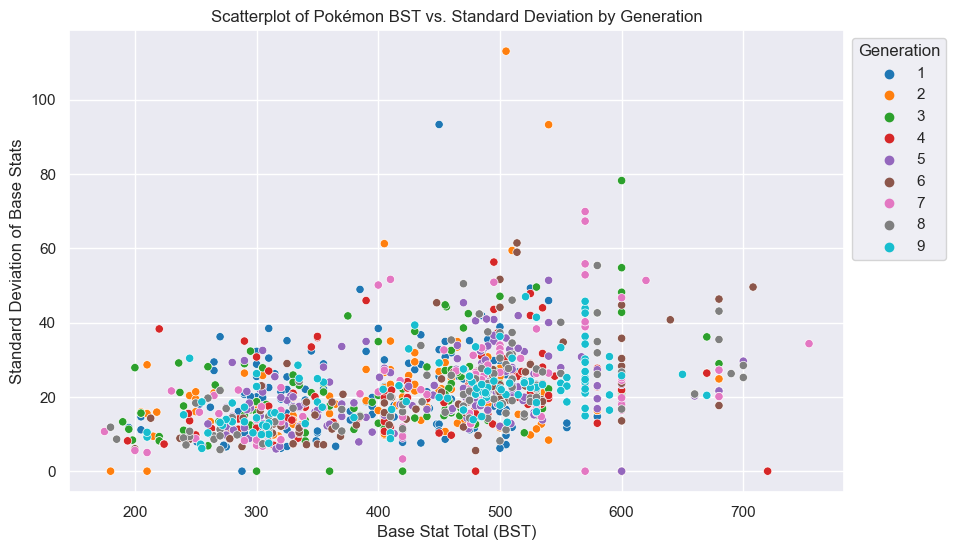

In [659]:
# make a scatterplot or a similar graph of all pokemon with bst on x and standard deviation on y and color them by generation

# calculate the standard deviation of the 6 base stats for each pokemon
pokedf['StdDev'] = pokedf[['HP', 'Attack', 'Defense', 'Sp. Attack', 'Sp. Defense', 'Speed']].std(axis=1)

# create a scatterplot with colors by gen
plt.figure(figsize = (10, 6))
sns.scatterplot(data = pokedf, x = 'BST', y = 'StdDev', hue = 'Generation', palette = master_generation_colors)

# set plot labels and title
plt.xlabel('Base Stat Total (BST)')
plt.ylabel('Standard Deviation of Base Stats')
plt.title('Scatterplot of Pokémon BST vs. Standard Deviation by Generation')

# show legend
plt.legend(title = 'Generation', loc = 'upper left', bbox_to_anchor = (1, 1))
plt.show()

I ended up attempting to use the standard deviation of the 6 base stats as a proxy to check for optimized Pokemon. The reasoning was that if better min/maxed Pokemon have larger gaps between their stats, they would tend to have a higher standard deviation. Surprisingly, there is very little noticeable difference between generations and their standard deviation distribution.

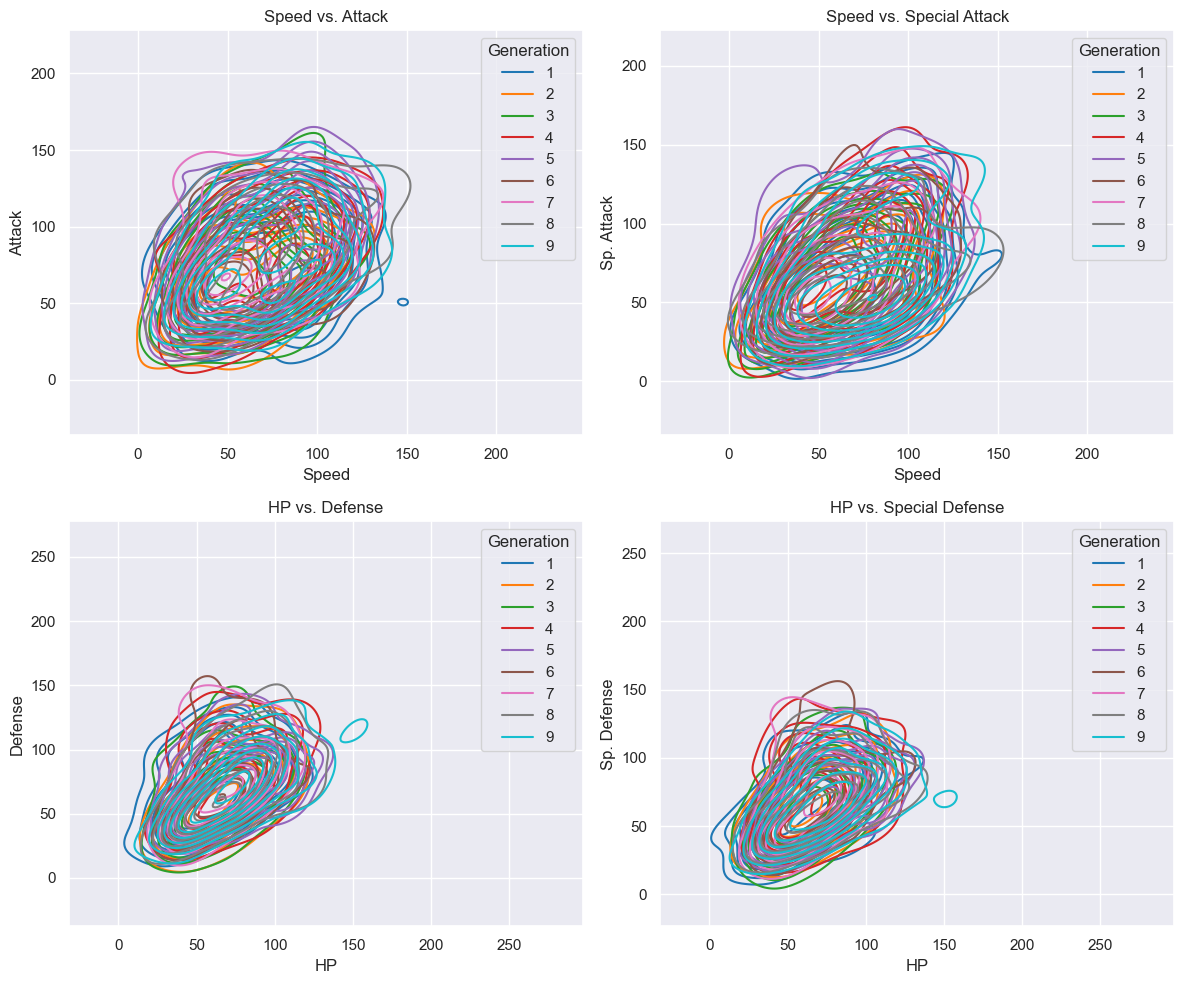

In [660]:
# subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# plot 1: Speed vs Attack
sns.kdeplot(
    data = pokedf,
    x = "Speed",
    y = "Attack",
    hue = "Generation",
    thresh = .1,
    palette = master_generation_colors,
    ax = axs[0, 0]
)
axs[0, 0].set_title("Speed vs. Attack")

# plot 2: Speed vs Sp Attack
sns.kdeplot(
    data = pokedf,
    x = "Speed",
    y = "Sp. Attack",
    hue = "Generation",
    thresh = .1,
    palette = master_generation_colors,
    ax = axs[0, 1]
)
axs[0, 1].set_title("Speed vs. Special Attack")

# plot 3: HP vs Defense
sns.kdeplot(
    data = pokedf,
    x = "HP",
    y = "Defense",
    hue = "Generation",
    thresh = .1,
    palette = master_generation_colors,
    ax = axs[1, 0]
)
axs[1, 0].set_title("HP vs. Defense")

# plot 4: HP vs Sp Defense
sns.kdeplot(
    data = pokedf,
    x = "HP",
    y = "Sp. Defense",
    hue = "Generation",
    thresh = .1,
    palette = master_generation_colors,
    ax = axs[1, 1]
)
axs[1, 1].set_title("HP vs. Special Defense")

# Adjust layout
plt.tight_layout()

# Show the subplots
plt.show()


Here too, there isn't much of a noticeable difference in distribution of stats. The one exception is a set of extremely defensive Pokemon in generation 9.

## <h1 style="text-align: center;">Conclusions</h1>